In [32]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data_path = 'data/wrap_data_10000_ordered.csv'
data_df = pd.read_csv(data_path, dtype = float)

training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [13]:
learning_rate = 0.0015
training_epochs = 100

layer_1_nodes = 80
layer_2_nodes = 280
layer_3_nodes = 500

In [14]:
import tensorflow as tf

In [39]:
logdir = 'tau_test_ordered/'
layer_code = '80_280_500_c'

tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-05).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

In [40]:
saver = tf.train.Saver()

with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + layer_code + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + layer_code + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)

        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + layer_code + 'model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

In [17]:
import matplotlib.pyplot as plt

In [41]:
with tf.Session() as session:
    saver.restore(session,'logs/tau_test_ordered/80_280_500_cmodel/trained_model.ckpt')
    
    X_to_pred = X_scaler.transform(X_testing[:])
    prediction_scaled = session.run(prediction, feed_dict = {X: X_to_pred})
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
    
#     pred_vals = prediction.T[0]
#     plt.plot(pred_vals)
#     plt.show()
    
#     act_vals = Y_testing.T[0]
#     plt.plot(act_vals)
#     plt.show()

INFO:tensorflow:Restoring parameters from logs/tau_test_ordered/80_280_500_cmodel/trained_model.ckpt


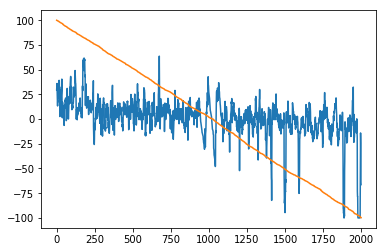

In [43]:

plt.plot((prediction_unscaled.T[0]))
plt.plot((Y_testing.T[0]))
plt.show()

In [27]:
Y_testing.T[0].shape

(2000,)

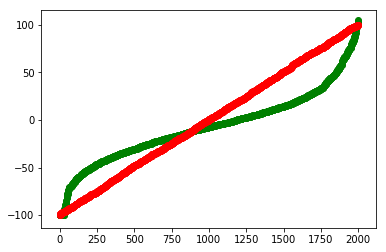

In [107]:

plt.scatter(range(len(prediction_unscaled.T[0])), sorted(prediction_unscaled.T[0]), color = 'green')
plt.scatter(range(len(prediction_unscaled.T[0])), sorted(Y_testing.T[0][:]), color = 'red')

plt.show()

In [101]:
prediction_unscaled.T[0]

array([-46.677063 , -21.693924 ,  -2.4275954,  -9.708442 ,  32.056538 ,
       -11.688241 , -30.18643  , -85.73218  ,   0.6899467,   3.7849689,
        21.211967 , -32.10462  ,  32.604202 ,  46.54869  , -30.71954  ,
       -17.539192 ,  15.277401 , -59.96058  ,  20.519842 , -32.201523 ,
       -19.418093 , -37.76217  ,  67.39001  , -34.185535 ,  11.208203 ,
       -22.105997 , -41.048172 ,   1.8485589,  53.13902  ,  23.131327 ,
        -7.089235 ,  53.033497 ,   9.792971 , -56.93134  , -21.993206 ,
       -13.835296 ,  -3.869739 ,   1.5422751, -24.724669 ,   1.3974917,
       -13.205236 , -50.18018  ,  20.773699 , -22.493698 ,  29.00945  ,
        -1.6869079,   4.5421653, -65.40788  , -99.92044  ,  -8.6904545],
      dtype=float32)

In [37]:
X_to_pred

array([[0.42220915, 0.41823604, 0.41428976, ..., 0.35255184, 0.34863694,
        0.34472286]])

In [41]:
X_scaler.transform(X_testing[0:2])

array([[0.42220915, 0.41823604, 0.41428976, ..., 0.35255184, 0.34863694,
        0.34472286],
       [0.7480697 , 0.75325201, 0.75840568, ..., 0.98609691, 0.99119301,
        0.9966876 ]])